# $Re$ corrections to static foil data

In this notebook we evaluate methods for correcting static foil data for Reynolds number effects.

We will use the Sheldahl and Klimas (1981) NACA 0021 datasets.

Yamauchi and Johnson (1983) proposed a simple correction derived from turbulent flat
plate boundary layer results, where the drag coefficient is corrected as

\begin{equation}
    C_d = C_{d_{\mathrm{table}}}/ K,
\end{equation}

where $K = f(Re_\mathrm{table})/f(Re)$. There are several choices for the
scaling function $f(Re)$:

\begin{equation}
    f(Re) = Re^{-0.5},
\end{equation}

\begin{equation}
    f(Re) = Re^{-0.2},
\end{equation}

\begin{equation}
    f(Re) = \frac{0.455}{\ln Re}2.58 - \frac{A}{Re},
\end{equation}

\begin{equation}
    f(Re) = (3.46 \ln Re - 5.6)^{-2},
\end{equation}

or

\begin{equation}
    f(Re) = (\ln Re - 0.407)^{-2.64}.
\end{equation}

Yamauchi and Johnson propose a correction for the lift coefficient that will
keep the lift slope constant, i.e.

\begin{equation}
    C_l = K C_{l_\mathrm{table}} (\alpha/K),
\end{equation}

where

\begin{equation}
    K = \alpha_{\max} / \alpha_{\max_\mathrm{table}} = C_{l_{\max}} /
    C_{l_{\max_\mathrm{table}}}.
\end{equation}

The scaling constant is chosen as

\begin{equation}
    K = \left( Re/Re_\mathrm{table} \right)^n,
\end{equation}

where $n$ is a small positive number between approximately 0.125 and 0.2.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
from pxl.styleplot import set_sns
set_sns()

C:\Users\Pete\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


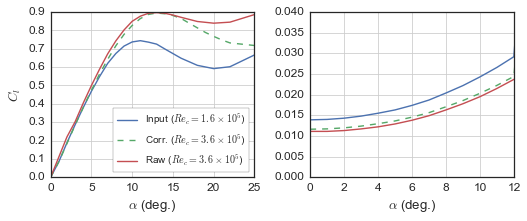

In [20]:
def load_data(Re, alpha_deg_max=25):
    """Load foil data."""
    fname = "data/NACA0021_{:.1e}.csv".format(Re).replace("+0", "")
    df = pd.read_csv(fname)
    return df[df.alpha_deg <= alpha_deg_max]


def lookup(df, alpha_deg, quantity="cl"):
    """Lookup specified quantity at given angle of attack using linear interpolation."""
    alpha_deg = np.asarray(alpha_deg)
    f = interp1d(df.alpha_deg, df[quantity])
    return f(alpha_deg)
    

def correct_cl(df, Re, Re_table, n=0.125):
    """Correct lift coefficient."""
    K = (Re/Re_table)**n
    df["cl_corr"] = K*lookup(df, df.alpha_deg/K, quantity="cl")
    return df


def f_Re_a(Re):
    return Re**(-0.5)


def f_Re_b(Re):
    return Re**(-0.2)


def f_Re_c(Re):
    A = None # ???
    return 0.455/np.log(Re) * 2.58 - A/Re


def f_Re_d(Re):
    return (3.46*np.log(Re) - 5.6)**(-2)


def f_Re_e(Re):
    return (np.log(Re) - 0.407)**(-2.64)


def correct_cd(df, Re, Re_table, f_Re=f_Re_a):
    """Correct drag coefficient."""
    K = f_Re(Re_table)/f_Re(Re)
    df["cd_corr"] = df.cd/K
    return df
    

Re_low = 1.6e5
Re_high = 3.6e5
df = load_data(Re_low)
df = correct_cl(df, Re_high, Re_low, n=0.23)
df = correct_cd(df, Re_high, Re_low, f_Re=f_Re_e)
df_high = load_data(Re_high)

fig, ax = plt.subplots(figsize=(7.5, 3.25), ncols=2)

ax[0].plot(df.alpha_deg, df.cl, label=r"Input ($Re_c = {:.1f} \times 10^5$)".format(Re_low/1e5))
ax[0].plot(df.alpha_deg, df.cl_corr, linestyle="--",
           label=r"Corr. ($Re_c = {:.1f} \times 10^5$)".format(Re_high/1e5))
ax[0].plot(df_high.alpha_deg, df_high.cl, label=r"Raw ($Re_c = {:.1f} \times 10^5$)".format(Re_high/1e5))
ax[0].set_ylabel("$C_l$")
ax[0].legend(loc="best")
ax[1].plot(df.alpha_deg, df.cd)
ax[1].plot(df.alpha_deg, df.cd_corr, linestyle="--")
ax[1].plot(df_high.alpha_deg, df_high.cd)
ax[1].set_xlim((0, 12))
ax[1].set_ylim((0, 0.04))
for a in ax:
    a.set_xlabel(r"$\alpha$ (deg.)")
fig.tight_layout()
plt.show()